# Librerías

In [3]:
import os
import sys

import numpy as np
from numpy.random import seed
seed(42)
import pandas as pd 
import random
from glob import glob
import re
from scipy import interp  
from itertools import cycle


import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
%matplotlib inline
import cv2


from sklearn.metrics import SCORERS
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, label_binarize, OneHotEncoder
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, accuracy_score 
from sklearn.datasets import make_classification 
import sklearn


import tensorflow as tf


from keras.utils import layer_utils, np_utils
from keras.preprocessing.image import ImageDataGenerator  
from keras.applications import densenet, vgg16, nasnet  
from keras.models import Sequential, Model, load_model  
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D,Input
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input, decode_predictions
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from keras.optimizers import SGD
from keras.wrappers.scikit_learn import KerasClassifier
from keras import regularizers  
from keras import backend as K 


import pickle

Using TensorFlow backend.


# Importar imágenes

## Funciones

In [4]:
def open_images_names(directory):
    
    """
    **************************************************************
    
    Abre las imagenes de un directorio y las almacena en un array.
    Extrae el nombre del artista del path de la imagen.
    
    Input:
    *directory. Path en el que se encuentran las imágenes.
    Output:
    *np.array con la información de las imágenes
    *np.array con el nombre del artista.
    
    ***************************************************************
    """
    
    images_all = []
    images = glob(directory)
    i_ = 0
    
    for img in images:
        im = cv2.imread(img)
        images_all.append(np.asarray(im))
        i_ += 1
    
    artists = []
    for artist in images:
        art = re.sub("_", " ", (",").join(re.findall("\w+_", artist))[:-1])
        
        if art == "Albrecht ,rer":
            artists.append("Albrecht Dürer")
        else:
            artists.append(art)

        
    return images_all, artists

In [5]:
def muestra(bd): 
    
    """
    **************************************************************
    
    Muestra de forma aleatoria una de las imágenes importadas junto
    con información de su tamaño y autor.
    
    ***************************************************************
    """
    
    plt.rcParams['figure.figsize'] = (8, 15) 
    
    num = random.randrange(len(images))
    print(f'Autor: {artists[num]}')
    print(f'Dimensión:{bd[num].shape}')
    print(f'Alto: {bd[num].shape[0]} px.')
    print(f'Ancho: {bd[num].shape[1]} px.')
    print(f'Profundidad: {bd[num].shape[2]} (RGB)')

    plt.imshow(cv2.cvtColor(bd[num], cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

## Proceso

Aplicando la función <code>open_images_names</code> obtendremos las imágenes a analizar junto a una lista con los nombres que se extraen del archivo, y solo habrá que pasarle la dirección del directorio donde están nuestras imagenes junto con <k>/**</k> para que extraiga todos los archivos que hay dentro.

In [6]:
images, artists = open_images_names("images/**")

Echaremos un primer vistazo al tamaño que tiene nuestros inputs.

In [7]:
print(f'Disponemos de un total de {len(images)} imagenes con {len(pd.unique(artists))} artistas diferentes, entre los que encontramos a {pd.unique(artists)[random.randrange(len(pd.unique(artists)))]}, {pd.unique(artists)[random.randrange(len(pd.unique(artists)))]} o {pd.unique(artists)[random.randrange(len(pd.unique(artists)))]}.')

Disponemos de un total de 8683 imagenes con 50 artistas diferentes, entre los que encontramos a Henri de ,Lautrec, Edouard Manet o Gustave Courbet.


Con la función <code>muestra</code> podemos ver una imagen al azar de nuestra colección junto al nombre del artista y el tamaño. Cada vez que se ejecute saldrá una diferente.

Autor: Albrecht Dürer
Dimensión:(1229, 870, 3)
Alto: 1229 px.
Ancho: 870 px.
Profundidad: 3 (RGB)


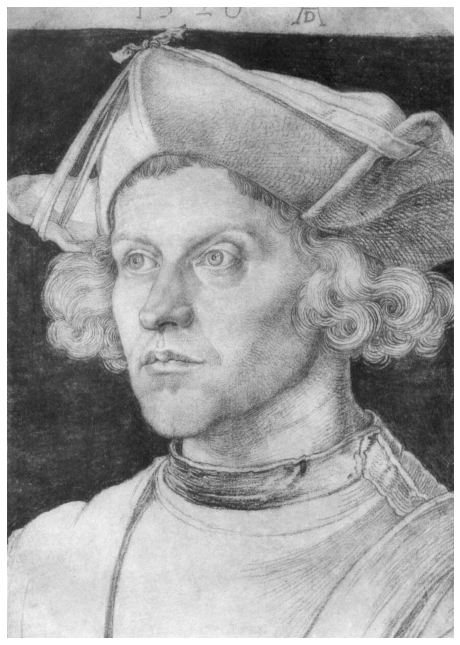

In [8]:
muestra(images)

# Corregir problemas de balanceo

## Funciones

In [9]:
def top_artists(df, y, num):
    
    """
    **************************************************************
    
    Divide la información en dos datasets diferentes usando la media
    del total de observaciones por categorías como separación.
    
    Input:
    df: dataframe a separar.
    y: variable dependiente.
    
    Output:
    *big_df: dataframe con las categorías con más observaciones.
    *small_df: dataframe con las categorías con menos observaciones.
    
    ***************************************************************
    """
    
    # Crea una lista con las etiquetas de categoría con más observaciones y otra con las que tienen menos.
    
    c = list(df['artist'].value_counts()[:num].index)
            
    # Crea dos dataframes agrupando según las categorías listadas en el paso anterior.
            
    big_df = []
    for i in c:
        big_df.extend(np.array(df[df[y] == i]))
    big_df = pd.DataFrame(big_df, columns = df.columns)

            
    return big_df

In [10]:
def visualice(df_big, df_small):
    
    """
    **************************************************************
    
    Muestra dos barplots con los artistas que se han separado.
    
    Input:
    df_big: dataframe con los artistas con más cuadros.
    df_small: dataframe con los artistas con menos cuadros.
    
    Output:
    * Barplots con ambas distribuciones
    
    ***************************************************************
    """

    print(f' El tamaño original es de {df_big.shape}. A partir de ahora trabajarás con {df_small.shape}.')
          
    fig = plt.figure(figsize=(15,5))

    fig.add_subplot(121)
    plt.title('Dataset original', fontsize=14)
    artists_plot1 = sns.countplot(df_big['artist'], color = "blue")
    _=artists_plot1.set_xticklabels(artists_plot1.get_xticklabels(), rotation=65, horizontalalignment='right')
    fig.add_subplot(122)
    
    plt.title('Nueva selección', fontsize=14)
    artists_plot2 = sns.countplot(df_small['artist'], color = "blue")
    _=artists_plot2.set_xticklabels(artists_plot2.get_xticklabels(), rotation=65, horizontalalignment='right')

In [11]:
def countplot_df(df, col):
    
    """
    **************************************************************
    Devuelve un gráfico de barras con los parámetros de visualización
    indicados
    Input:
    *df: dataframe del que extraer la información
    *col: columna que se quiere contar.
    **************************************************************
    
    """
    
    plt.rcParams['figure.figsize'] = (15, 8) 
    plot_df = sns.countplot(df[col], color = "blue")
    _ = plot_df.set_xticklabels(plot_df.get_xticklabels(), rotation=65, horizontalalignment='right')

## Proceso

Generaremos una estructura de DataFrame para poder corregir los problemas de desbalanceo que hemos visto. Hacemos el cambio de estructura desde nuestras imágenes.

In [12]:
df = pd.DataFrame(images, columns = ['images'])

Añadimos la columna con los nombres de los artistas.

In [13]:
df['artist'] = artists

Echamos un vistazo al DataFrame creado y observamos la siguiente estructura:

In [14]:
df.head()

,images,artist
0,"[[[35, 43, 72], [17, 25, 54], [26, 34, 63], [1...",Giotto di Bondone
1,"[[[254, 254, 254], [252, 254, 254], [249, 255,...",Vasiliy Kandinskiy
2,"[[[44, 70, 77], [87, 113, 120], [80, 106, 112]...",Kazimir Malevich
3,"[[[38, 35, 31], [36, 33, 29], [35, 32, 28], [3...",Titian
4,"[[[83, 69, 87], [75, 61, 79], [66, 52, 70], [6...",Diego Velazquez


Podemos observar por ejemplo que disponemos de más de 800 cuadros de Van Gogh, frente a unos 50 de Cezanne. Hay diferentes estrategias que podemos seguir para corregir este problema:
* Empezaremos probando con una selección de artistas que tengan el número de obras más balanceadas.

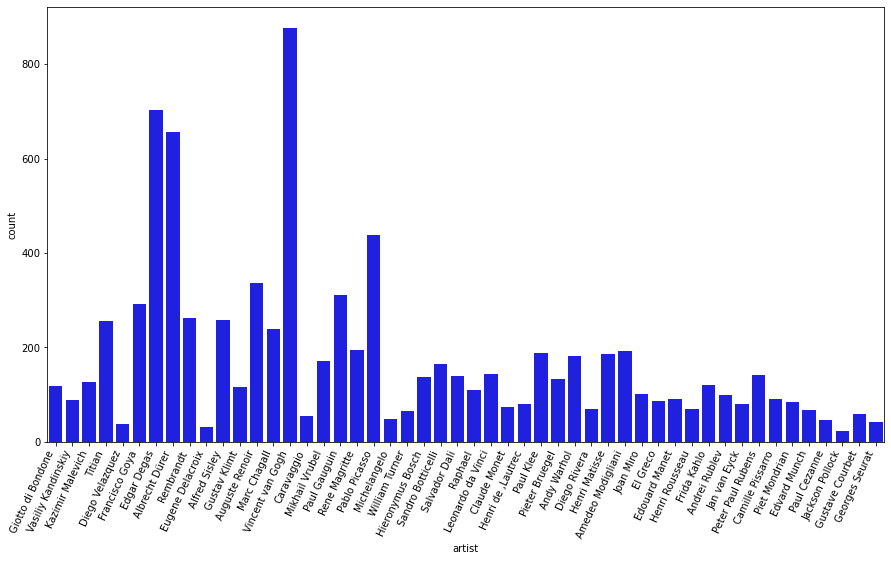

In [15]:
countplot_df(df, 'artist')

Nos quedamos con una selección de los 5 artistas con más obras para nuestra primera fase del entreno.

In [16]:
version1 = top_artists(df, 'artist', 5)

Dataset original vs dataset con la selección.
 El tamaño original es de (8683, 2). A partir de ahora trabajarás con (3010, 2).


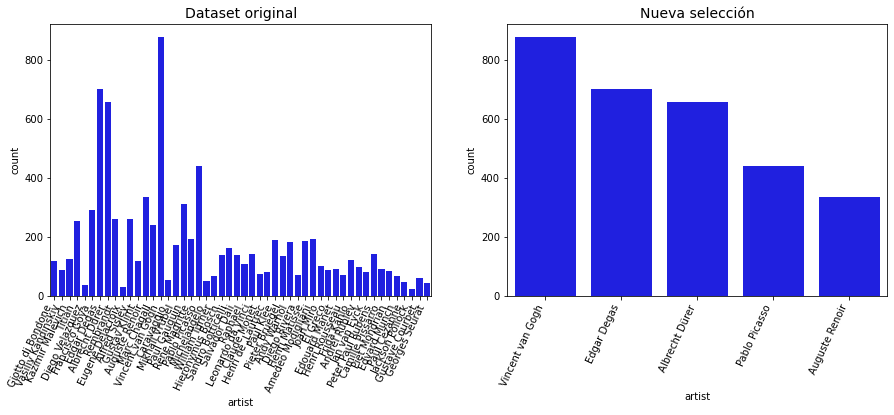

In [17]:
print("Dataset original vs dataset con la selección.")
visualice(df, version1)

# Separar *train*, *test* y *validation*

Ahora podemos generar nuestra *X* y nuestra *y* desde la selección realizada en el paso anterior, paa a continuación almacenar el número total de elementos de la variable dependiente, aplicar la función <code>LabelEncoder()</code> para codificar las etiquetas, y crear un diccionario al que después recurrir para las visualizaciones, así como una lista con las etiquetas. A partir de aquí se puede separar el conjunto de entreno, test y validación y crear una secuencia de 0 y 1 para la variable dependiente.

In [18]:
images_v1=np.asarray(version1['images'])
artists =version1['artist']

In [19]:
num_classes = len(pd.unique(artists))

In [20]:
le=LabelEncoder()
le_artists = le.fit_transform(artists)
artists_dict = {}
for i in range(0, len(artists)):
    artists_dict[le_artists[i]]=artists[i]

In [21]:
artists_dict

{4: 'Vincent van Gogh',
 2: 'Edgar Degas',
 0: 'Albrecht Dürer',
 3: 'Pablo Picasso',
 1: 'Auguste Renoir'}

In [22]:
target_names = [artists_dict.get(i) for i in sorted(artists_dict)]

Procedemos a separar el conjunto de entreno, test y validación.

In [23]:
x_train_original, x_test_original, y_train_original, y_test_original = train_test_split(images_v1, le_artists, test_size=0.2, random_state=42)

In [24]:
x_train_original, x_val_original, y_train_original, y_val_original = train_test_split(x_train_original, y_train_original, test_size=0.2, random_state=42)

Creamos una secuencia de 0 y 1 para nuestra variable dependiente.

In [25]:
#Esto convierte a OneHotEncoding

y_train = np.array(np_utils.to_categorical(y_train_original, num_classes))
y_val = np_utils.to_categorical(y_val_original, num_classes)
y_test = np_utils.to_categorical(y_test_original, num_classes)

# Data Wrangling

## Ajustar el tamaño de las imágenes

### Funciones

In [26]:
def resize_data(data):  
    
    """
    **************************************************************
    
    Ajusta el tamaño de la imagen para su estandarización.
    
    ***************************************************************
    """
    
        
    res_data = []
    for i in range(len(data)):
        res = cv2.resize(data[i], dim, interpolation=cv2.INTER_LINEAR)
        res_data.append(res)

    return res_data

In [27]:
def compara_muestras(db1, db2):
        
    """
    **************************************************************
    
    Muestra de forma aleatoria una de las imágenes importadas junto
    con información de su tamaño y autor.
    
    ***************************************************************
    """
    
    plt.rcParams['figure.figsize'] = (15, 8) 
    
    num = random.randrange(len(db1))
    
    print(f'Autor: {artists[num]}')
    print(f'Dimensión original:{db1[num].shape}')
    print(f'Dimensión ajustada:{db2[num].shape}')
    print(f'Filas originales: {db1[num].shape[0]}')
    print(f'Filas ajustadas: {db2[num].shape[0]}')
    print(f'Columnas originales: {db1[num].shape[1]}')
    print(f'Columnas ajustadas: {db2[num].shape[1]}')
    print(f'Profundidad: {db1[num].shape[2]}')
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('Imagen original vs imagen ajustada')

    ax1.imshow(cv2.cvtColor(db1[num], cv2.COLOR_BGR2RGB))
    ax1.axis('off')
    ax1.set_title("Imagen original")
    ax2.imshow(cv2.cvtColor(db2[num], cv2.COLOR_BGR2RGB))
    ax2.axis('off')
    ax2.set_title("Imagen ajustada")
    plt.show()

### Proceso

Las imágenes que forman la colección tienen diferentes tamaños; habrá que establecer un tamaño común para poder entrenar el algoritmo. En este caso, limitando el tamaño a una dimensión de 100px para que los modelos puedan ejecutarse más rápido, mediante la función <code>resize_data</code>.

In [28]:
dim = (100, 100)

In [29]:
x_train = np.asarray(resize_data(x_train_original))

In [30]:
x_test = np.asarray(resize_data(x_test_original))

In [31]:
x_val = np.asarray(resize_data(x_val_original))

Comparamos la imagen original con el ajuste.

Autor: Albrecht Dürer
Dimensión original:(496, 236, 3)
Dimensión ajustada:(100, 100, 3)
Filas originales: 496
Filas ajustadas: 100
Columnas originales: 236
Columnas ajustadas: 100
Profundidad: 3


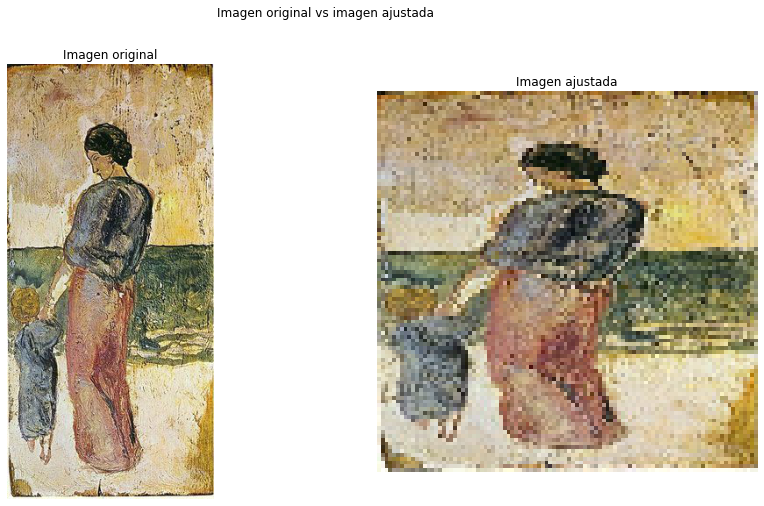

In [32]:
compara_muestras(x_train_original, x_train)

Claramente la imagen ha perdido bastante calidad. Veamos cómo reaccionan los modelos.

## DataAugmentation

Ahora se pueden establecer parámetros para la creación de nuevas imágenes a partir de modificaciones de la original. Estas variaciones permiten aprovechar cada parte de la imagen para encontrar patrones, lo cual es muy útil cuando hay pocas imágenes y hará que el modelo generalice mejor.
* **rotation_range**: Número máximo de grados que la imagen se puede inclinar.
* **width shift range, height shift range**: Cambia de orientación los píxeles de algunas partes de la imagen.
* **shear_range**: Modifica algunas partes de la imagen manipulando la orientación.
* **zoom_range**: Aplica un acercamiento a la imagen.
* **horizontal_flip**: Cambia la orientación de la imagen.
* **fill_mode**: Los píxeles cercanos se repiten para rellenar las áreas que una rotación haya podido dejar vacías.

In [33]:
#Este está creado para la visualización
train_generator_viz = ImageDataGenerator(
        rotation_range = 20,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        fill_mode = 'nearest')

#Este es el que pasaremos al modelo con el rescalado de valores
train_generator = ImageDataGenerator(
        rotation_range = 20,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        fill_mode = 'nearest',
        rescale = 1.0/255)

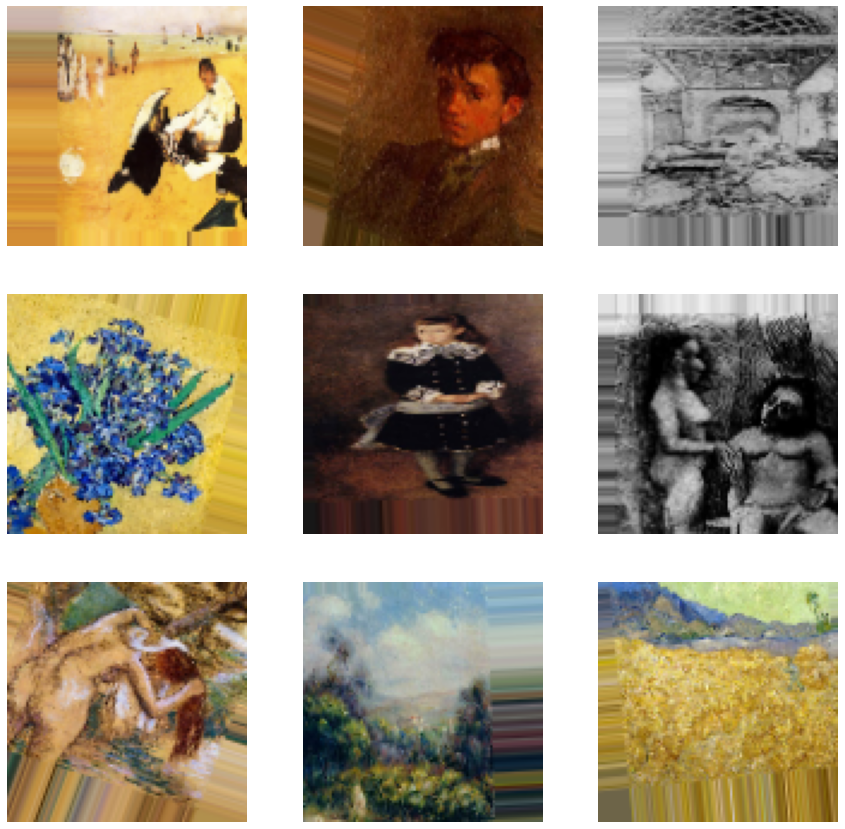

In [34]:
fig = plt.figure(figsize=(15,15))

for i in range(9):
    plt.subplot(330 + 1 + i)
    batch = train_generator_viz.flow(x_train).next()
    image = batch[0].astype('uint8')
    plt.axis('Off')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.show()

# Elegir el modelo

## Algunas consideraciones previas

**¿Qué es una red neuronal?**

La idea principal que hay detrás de las **redes neuronales** es la de imitar el funcionamiento de las de los organismos vivos: un conjunto de neuronas conectadas entre sí que trabajan en conjunto. Con la experiencia, las neuronas van creando y reforzando ciertas conexiones para "aprender". La información de entrada atraviesa la neurona, donde se llevan a cabo determinadas operaciones, produciendo unos valores de salida.

Las redes neuronales son un modelo para encontrar esa combinación de parámetros y aplicarla al mismo tiempo. Una red ya entrenada se puede usar luego para hacer predicciones o clasificaciones con otros datos.

<img src="img/red ejemplo.png" width="400" height="400"/>

Antes de comenzar a probar modelos habrá que determinar objetivos en los resultados. Para ello son útiles las métricas que indicarán si el modelo está haciendo bien el trabajo, empezando por los indicadores:


**Métricas de evaluación del modelo**:

* **loss**: Compara el resultado predicho con el resultado correcto. Cuanto más próximo a 0 mejor, ya que se busca la menor divergencia posible.

* **mse**: El *error cuadrático medio* (median standard error) es una función de coste. Se pueden utilizar métodos estadísticos formales para determinar la confianza del modelo entrenado. 

* **learning rate**: El valor adecuado de este hiperparámetro depende del problema en cuestión. En general, si el modelo de aprendizaje no funciona, es buena idea reducir la learning rate. Si el gradiente de la función de loss es pequeño, se pueden probar learning rate que compensen el gradiente.

* **acurracy**: Porcentaje de casos en que el modelo ha acertado. No distingue entre tipos de errores. Debe interpretarse con cuidado, ya que un mal modelo puede dar buenos resultados cuando las clases están desbalanceadas. En este proyecto será muy útil dado que no son relevantes los falsos negativos ni los falsos positivos.

* **precision**: Mide la **calidad** del modelo. Es el resultado de dividir verdaderos positivos entre la suma de verdaderos positivos y falsos positivos.

* **recall**: Aporta información sobre la **cantidad** de elementos que es capaz de identificar. Es el resultado de dividir verdaderos positivos entre la suma de verdaderos positivos y falsos negativos.
* **f1**: El Valor-F combina precision y recall en un solo valor, siendo el resultado de multiplicar por dos el producto de la precision y el recall entre la suma de los mismos.

Mediremos la eficacia del modelo con la *accuracy*.

### Funciones

In [35]:
def conf_matrix(num_classes, model_pred):
    
    """
    **************************************************************
    
    Crea una matriz de confusión del modelo.

    ***************************************************************
    """
    
    #Creamos la matriz de confusión
    model_cm = confusion_matrix(np.argmax(y_test, axis=1), model_pred)

    # Visualizamos la matriz de confusión
    model_df_cm = pd.DataFrame(model_cm, range(num_classes), range(num_classes))  
    plt.figure(figsize = (20,14))  
    sns.set(font_scale=1.4) #for label size  
    sns.heatmap(model_df_cm, annot=True, annot_kws={"size": 12},cmap="Blues", center =30, xticklabels=target_names, yticklabels=target_names)  
    plt.show() 

In [36]:
def plot_train_vs_val (model):
    
    """
    **************************************************************
    
    Visualiza en forma de gráfico las curvas del accuracy y del loss
    entre el train y el test.

    ***************************************************************
    """
    
    plt.rcParams['figure.figsize'] = (8, 6) 
    
    plt.figure(0)  
    plt.plot(model.history['acc'],'r')  
    plt.plot(model.history['val_acc'],'g')  
    plt.xticks(np.arange(0, 50, 2.0))   
    plt.xlabel("Num of Epochs")  
    plt.ylabel("Accuracy")  
    plt.title("Training Accuracy vs Validation Accuracy")  
    plt.legend(['train','validation'])

    plt.figure(1)  
    plt.plot(model.history['loss'],'r')  
    plt.plot(model.history['val_loss'],'g')  
    plt.xticks(np.arange(0, 50, 2.0))   
    plt.xlabel("Num of Epochs")  
    plt.ylabel("Loss")  
    plt.title("Training Loss vs Validation Loss")  
    plt.legend(['train','validation'])

    plt.show()

In [37]:
def test_img(model_predicted):
    
    """
    **************************************************************
    
    Devuelve una imagen con el resultado del modelo de predicción
    indicado.
    
    Input:
    -model_predicted: resultados del modelo con el test.
    
    Output:
    -Imagen con la predicción.
    
    
    ***************************************************************
    """
    
    
    #Genera la elección aleatoria de la imagen
    num = random.randrange(len(y_test))
    
    #Imprime la imagenx
    plt.imshow(cv2.cvtColor(x_test_original[num], cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    
    #Busca en el diccionario para devolver el nombre del artista y no la etiqueta
    real= artists_dict.get(np.argmax(y_test[num]))
    predicted= artists_dict.get(model_predicted[num])
    
    #Muestra la etiqueta real y la predicha.
    print(f'Artista real      :   {real}')  
    print(f'Artista predicho  :   {predicted}') 

In [38]:
def guardar(model, model_name):
    
    """
    **************************************************************
    
    Guarda el modelo en formato h5 y su histórico en txt.
    
    Input:
    -model: modelo a guardar
    
    Output:
    -Imagen con la predicción
    
    
    ***************************************************************
    """
    #Modelo
    model.save(model_name+'.h5')
    #Histórico
    with open(model_name + '.txt', 'wb') as file_pi:  
        pickle.dump(model.history, file_pi)

In [39]:
K.set_image_data_format('channels_last')  

In [40]:
K.set_learning_phase(1) 

## Hiperparamétros

Los **hiperparámetros** se utilizan para describir la configuración del modelo. No se utilizan para modelar los datos directamente, pero influyen en la capacidad y características de aprendizaje del modelo. 

Las funciones <code>callback</code> son aquellas que se pasan a otra función como argumento y se ejecutan dentro de esta. En este proyecto se aplicarán las siguientes:

* **EarlyStopping**: Para cuando la función de coste no mejore en un número dado de epochs. Ayudará reduciendo el **overfitting**. Para ello se marca <code>verbose</code> en 1, para saber el epoch en el que el modelo se ha parado. Con <code>patience</code> se indicará cuántos epochs tienen que pasar para que el entrenamiento pare y con <code>min_delta</code> se establece un incremento específico de mejora para el error cuadrático.


* **ReduceLROnPlateau**: Si el entrenamiento no mejora tras unos epochs específicos, reduce el valor de learning rate del modelo, lo que normalmente supone una mejora del entrenamiento. Ahora bien, el mejor learning rate suele ser aquel que disminuye a medida que el modelo se acerca a una solución.

In [41]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, min_delta=1e-4)  
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4)  
callbacks = [early_stop, reduce_lr] 

* **Batch**: Define el número de muestras para trabajar antes de actualizar los paramétros internos del modelo. Las predicciones se comparan con las variables de salidad esperadas y se calcula el error. A partir de este error el algoritmo se actualiza para mejorarse.

    * **Batch Gradient Descent**. Cuando el tamaño del bach es igual que el del conjunto de entrenamiento.
    * **Stochastic Gradient Descent**. Cuando el tamaño del bach es igual a 1.
    * **Mini-Batch Gradient Descent**. Cuando el tamaño del bach está entre uno y el tamaño del conjunto de entrenamiento.
    
    
* **Epoch**: Se trata de un hiperparámetro que define el número de veces que el algoritmo de aprendizaje funcionará sobre el conjunto de datos de entrenamiento. Cada muestra del conjunto de datos de entrenamiento tiene la "oportunidad" de actualizar los parámetros internos del modelo. Puede estar compuesto por uno o más *batches*. El número de *epochs* suele ser grande, lo que permite que el algoritmo se ejecute hasta que el error del modelo se minimice lo suficiente.

In [42]:
epochs = 100
batch_size = 32

Llegado el momento de compilar nuestro modelo usaremos la función <code>.compile()</code> con los siguientes parámetros:

* Una **función de *loss*** es un parámetro requerido para cuantificar lo cerca que está una red neuronal de su ideal durante el proceso de entrenamiento. Definimos nuestra función de pérdida en <code>loss</code> entre las opciones:
    * <code>'categorical_crossentropy'</code> : Calcula la pérdida de crossentropy entre los artistas y las predicciones. Se usa cuando hay dos o más etiquetas. Necesita de una representación <code>OneHotEncoding</code>.
    * <code>'sparse_categorical_crossentropy'</code> : Calcula la pérdida de crossentropy entre los artistas y las predicciones. Se usa cuando hay dos o más etiquetas. Necesita de una representación <code>LabelEncoder</code>.

* El **optimizador** es otro argumentos requerido en el método de compile(). El proceso de aprendizaje es un problema de optimización global donde los parámetros (pesos y sesgos) se deben ajustar de manera que la función de *loss* se minimice. Para el <code>optimizer</code> se usará:
    * <code>'Adam'</code>: implementa el algoritmo Adam. Se trata de un método de descenso de gradiente estocástico basado en la estimación adaptativa. Es computacionalmente eficiente, con pocos requisitos de memoria y adecuado para problemas con grandes cantidades de datos/parámetros.

En cuanto a métricas, en <code>metrics</code> utilizaremos *accuracy* y error cuadrático.

## Red Neuronal Simple

Una red neuronal es un grupo de nodos interconectado de forma similar a las neuronas de un cerebro. Una red neuronal simple se caracteriza por tener un número de entradas y un número de salidas. Cada entrada tendrá un peso e influirá en la salida de la neurona.

<img src="img/rnn_esquema.jpg"/>

### Creamos la red

Empecemos definiendo una red neuronal simple y algunos conceptos que se irán repitiendo a medida que aparezcan diferentes modelos:
* **Sequential()**: Agrupa de forma lineal las capas del modelo proporcionando características de capacitación e inferencia al modelo.
* **Flatten**: Convierte la matriz de entrada en un array de 1 dimensión (plano).
* **Dense**: Añade una capa oculta a la red neuronal.

* **Función de activación ReLu**: Anula los valores negativos y deja los positivos tal y como entran. Su ventaja radica en que tiene un comportamiento lineal para entradas positivas, lo que evita el "estancamiento" durante el entrenamiento. Se activa un solo nodo si la entrada está por encima de cierto umbral.

* **Función de salida SoftMax**: Da buenos resultados cuando el entrenamiento es multietiqueta pero no multiclase (hay muchos artistas diferentes pero todos son pintores). Asigna probabilidades decimales a cada clase en un caso de clases múltiples, de manera que terminen sumando 1. Esta restricción adicional permite que el entrenamiento converja más rápido.

Llegado este punto, se compila el modelo creado y se le pasan los parámetros para la función de pérdida, el optimizador y las métricas a tener en cuenta.
Con <code>.summary()</code> se puede ver un resumen de la red neuronal. Esta red calculó algo más de **3 millones** de parámetros.

In [43]:
def create_simple_nn(): 
    
    model = Sequential()
    model.add(Flatten(input_shape=x_train[0].shape, name="Input_layer"))
    model.add(Dense(100, activation='relu', name="Hidden_layer_1"))
    model.add(Dense(50, activation='relu', name="Hidden_layer_2"))
    model.add(Dense(num_classes, activation='softmax', name="Output_layer"))

    return model

In [44]:
snn_model = create_simple_nn()  

Compilamos el modelo creado y le pasamos los parámetros para la función de pérdida, el optimizador y las métricas a tener en cuenta.

In [45]:
snn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', 'mse'])

Con <code>.summary()</code> podemos ver un resumen de nuestra red neuronal.

In [46]:
snn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (Flatten)        (None, 30000)             0         
_________________________________________________________________
Hidden_layer_1 (Dense)       (None, 100)               3000100   
_________________________________________________________________
Hidden_layer_2 (Dense)       (None, 50)                5050      
_________________________________________________________________
Output_layer (Dense)         (None, 5)                 255       
Total params: 3,005,405
Trainable params: 3,005,405
Non-trainable params: 0
_________________________________________________________________


Podemos observar que tiene un total  de **3 millones de parámetros**.

### Entrenar el modelo

Ya solo queda entrenarla, para lo cual se le indican imágenes, pintores y parámetros establecidos previamente. Se usará la función <code>.fit_generator()</code> en lugar de <code>.fit()</code>, dado que permite llamar a las características que establecidas antes con <code>ImageDataGenerator</code> para aumentar el número de imágenes a analizar con pequeñas modificaciones.

Este modelo ha necesitado 11 *epochs* de los 100 establecidos al principio, al no pararse por la función de <code>EarlyStopping</code>. Podríamos concluir que para llegar a los resultados óptimos deberíamos aumentar este valor. Cada uno ha tardado uno 4 segundos, lo que ha hecho que el modelo tarde algo menos de **1 minuto** en total.

In [47]:
snn = snn_model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(x_train) // batch_size,
    epochs=epochs,
    verbose=1,
    callbacks = callbacks,
    validation_data=(x_val, y_val),
    shuffle=True) 

Epoch 1/100
60/60 [==============================] - 4s 70ms/step - loss: 4.3120 - acc: 0.3057 - mse: 0.2066 - val_loss: 451.7647 - val_acc: 0.3755 - val_mse: 0.2496
Epoch 2/100
60/60 [==============================] - 4s 65ms/step - loss: 1.5221 - acc: 0.4329 - mse: 0.1474 - val_loss: 171.9558 - val_acc: 0.4896 - val_mse: 0.2037
Epoch 3/100
60/60 [==============================] - 4s 67ms/step - loss: 1.4946 - acc: 0.4541 - mse: 0.1432 - val_loss: 291.4052 - val_acc: 0.3548 - val_mse: 0.2578
Epoch 4/100
60/60 [==============================] - 4s 67ms/step - loss: 1.4821 - acc: 0.4578 - mse: 0.1431 - val_loss: 264.1957 - val_acc: 0.4419 - val_mse: 0.2232
Epoch 5/100
60/60 [==============================] - 4s 66ms/step - loss: 1.3800 - acc: 0.4764 - mse: 0.1365 - val_loss: 198.0490 - val_acc: 0.4938 - val_mse: 0.2020
Epoch 6/100
60/60 [==============================] - 4s 66ms/step - loss: 1.3627 - acc: 0.4894 - mse: 0.1347 - val_loss: 221.2566 - val_acc: 0.4813 - val_mse: 0.2073

Epo

### Evaluación del modelo

La función <code>.evaluate_generator()</code> muestra las métricas *loss*, *accuracy* y *mse* que obtiene el modelo. Con estos primeros datos podemos ver cómo el comportamiento final de todos los parámetros es más que aceptable para una red neuronal simple. El *loss* es de 0.99, lo que indica un coste de computación alto; la *accuracy* es también aceptable, con algo más de la mitad de los casos acertados, y el *mse* es una cifrá relativamente baja. Estas métricas comparan el conjunto de test con el de validación, habrá que ver las métricas definitivas cuando las comparemos con el conjunto de test.

In [48]:
evaluation = snn_model.evaluate_generator(train_generator.flow(x_train, y_train, batch_size=batch_size), verbose=1) 
evaluation

61/61 [==============================] - 4s 64ms/step


[0.7605554461479187, 0.5519210696220398, 0.11668279767036438]

La función <code>plot_train_vs_test()</code> muestra el comportamiento de las métricas a lo largo de los *epochs*. Se puede observar en la gráfica de *accuracy* la aparente tendencia del modelo a seguir aumentando este parámetro a mayor número de *epochs*. En el gráfico de la función de pérdida vemos cómo el valor desciende rápidamente al principio para estancarse a partir de los 11 *epochs*.

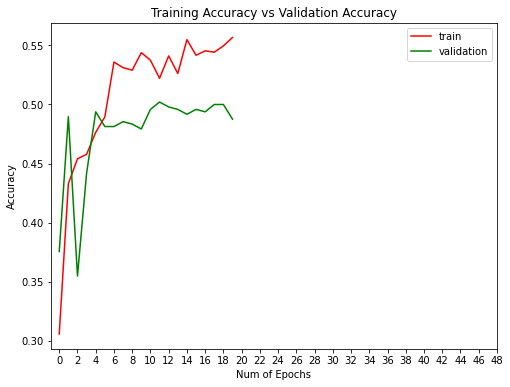

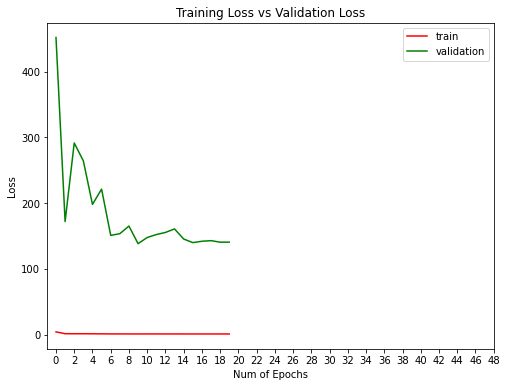

In [49]:
plot_train_vs_val(snn)

### Predicción del modelo

Una vez entrenado el modelo es posible consultar los resultados que obtenemos con el conjunto de datos de test. Una forma de hacerlo es mediante la matriz de confusión, donde se pueden apreciar las etiquetas reales (abscisas), frente a las predichas (ordenadas). El comportamiento y la capacidad de predicción son aceptables.

In [50]:
snn_pred = snn_model.predict(x_test, batch_size=32, verbose=1)  
snn_predicted = np.argmax(snn_pred, axis=1) 

602/602 [==============================] - 0s 109us/step


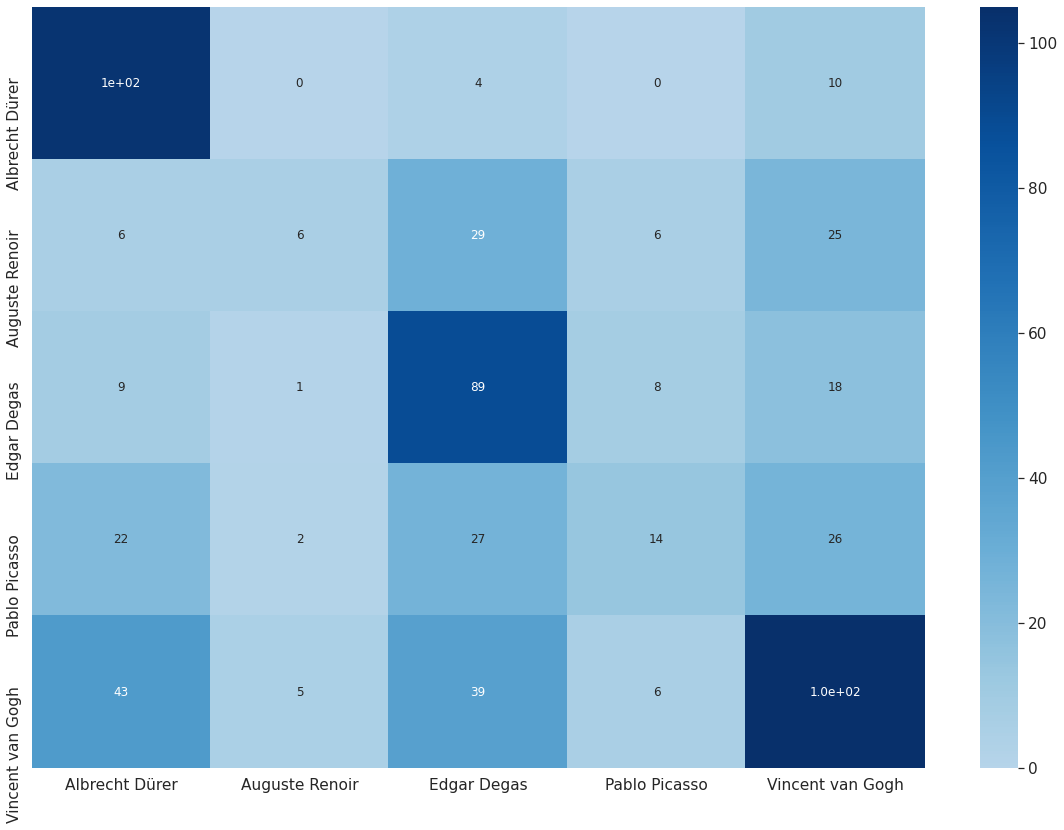

In [51]:
conf_matrix(num_classes, snn_predicted)

Las etiquetas de *Vincent Van Gogh* y *Albrecht Dürer* son las mejor clasificadas, y las que tienen mayor número de observaciones. Se obtiene así un 53% de *accuracy* al pasarle el conjunto de test.

In [52]:
snn_report = classification_report(np.argmax(y_test, axis=1), snn_predicted, target_names=target_names)  
print(snn_report)

                  precision    recall  f1-score   support

  Albrecht Dürer       0.56      0.88      0.68       116
  Auguste Renoir       0.43      0.08      0.14        72
     Edgar Degas       0.47      0.71      0.57       125
   Pablo Picasso       0.41      0.15      0.22        91
Vincent van Gogh       0.57      0.53      0.55       198

        accuracy                           0.52       602
       macro avg       0.49      0.47      0.43       602
    weighted avg       0.51      0.52      0.48       602



Presenta problemas al identificar a *Renoir* como podemos ver en el <code>classification_report</code>.

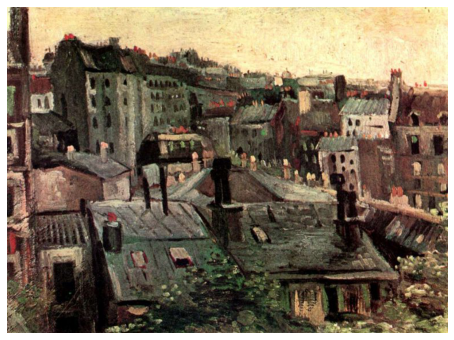

Artista real      :   Vincent van Gogh
Artista predicho  :   Edgar Degas


In [53]:
test_img(snn_predicted)

### Conclusiones

Tratándose de una red neuronal simple podemos considerar que ha dado muy buenos resultados. A continuación analizaremos el comportamiento del resto de redes para comparar y sacar mejores conclusiones.

### Guardar los resultados

Guardamos el histórico del modelo en un archivo <code>pickle</code> y su histórico en un txt con la función <code>guardar</code> que hemos creado antes.

In [54]:
guardar(snn_model, 'snn_model')

## Convultional Nets

Las neuronas de las redes neuronales convolucionales corresponden a campos receptivos de las neuronas de la corteza visual de un cerebro biológico. Han demostrado ser buenas para reconocer objetos en una imagen dado que permiten aprovecharla por partes. Contienen varias capas ocultas especializadas que detectan de forma jerarquica, partiendo de líneas para especializarse hasta poder reconocer formas concretas.

Las **convoluciones** consisten en tomar grupos de píxeles próximos y operar entre ellos generando una pequeña matriz o *kernel*. Este *kernel* recorre la imagen generando nuevas matrices, que, a su vez, vuelven a pasar por el proceso de convolución para finalmente obtener un mapa de detección de características.

<img src="img/ej_rnc.png" alt="ej_rnc"/>

### Crear la red

En este caso veremos los siguientes conceptos nuevos:

* **Conv2D**: Introduce una red convolucional, esta realiza el proceso de mover el kernel por toda la imagen y multiplicar los valores que encuentra. Habrá que indicarle como primer parámetro el número de kernels, después el tamaño de estos, el tamaño del input y el tipo de activación que queremos.
* **MaxPooling2D**: Para esta capa se pasa un kernel, pero en vez de multiplicar la información, toma el valor más grande de la sección de la imagen haciendo una sintetización de los kernels anteriores, para que no crezca exponencialmente el número de neuronas necesarias en la próxima capa. Con <code>pool_size</code> se indica el tamaño del kernel que usará esta capa.
* **Dropout**: Permite hacer redes con más capas.

Se seguirá el mismo proceso y estructura del modelo anterior.

In [55]:
def create_simple_cnn(): 
    
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), input_shape=x_train[0].shape, activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))

    model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(1024, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model

In [56]:
scnn_model = create_simple_cnn()   

In [57]:
scnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', 'mse'])

In [58]:
scnn_model.summary() 

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 46, 46, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 44, 44, 256)       295168    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 42, 42, 512)       1180160   
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 21, 21, 512)      

Esta red neuronal propone entrenar más de **47 millones de parámetros**, frente a los 3 millones de la red simple.

### Entrenar el modelo

Este modelo ha necesitado **11 *epochs*** de los 100 establecidos al principio, la función de <code>EarlyStopping</code> ha parado el entreno por no haber cambios significativos en las métricas. Cada uno ha tardado alrededor de 9 segundos, lo que ha hecho que el modelo tarde **1 minuto y medio** en ejecutarse.

In [59]:
scnn = scnn_model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(x_train) // batch_size,
    epochs=epochs,
    verbose=1,
    callbacks = callbacks,
    validation_data=(x_val, y_val),
    shuffle=True) 

Epoch 1/100
60/60 [==============================] - 16s 261ms/step - loss: 1.4500 - acc: 0.3907 - mse: 0.1430 - val_loss: 177.5221 - val_acc: 0.3527 - val_mse: 0.2568
Epoch 2/100
60/60 [==============================] - 9s 143ms/step - loss: 1.2192 - acc: 0.4704 - mse: 0.1265 - val_loss: 48.9115 - val_acc: 0.4191 - val_mse: 0.2284
Epoch 3/100
60/60 [==============================] - 9s 144ms/step - loss: 1.2124 - acc: 0.4757 - mse: 0.1258 - val_loss: 73.1727 - val_acc: 0.4585 - val_mse: 0.2152
Epoch 4/100
60/60 [==============================] - 9s 144ms/step - loss: 1.2189 - acc: 0.4900 - mse: 0.1267 - val_loss: 72.9565 - val_acc: 0.4336 - val_mse: 0.2249
Epoch 5/100
60/60 [==============================] - 9s 145ms/step - loss: 1.2319 - acc: 0.4799 - mse: 0.1262 - val_loss: 88.5399 - val_acc: 0.3444 - val_mse: 0.2591
Epoch 6/100
60/60 [==============================] - 9s 146ms/step - loss: 1.2046 - acc: 0.4831 - mse: 0.1254 - val_loss: 132.0572 - val_acc: 0.3963 - val_mse: 0.2357



### Evaluación del modelo

Con estos primeros datos ya es visible la mejora en el coportamiento final de todos los parámetros respecto al modelo anterior. El *loss* es de 1.006, lo que indica un coste alto, la *accuracy* mejora ligeramente empezando a verse aceptable. El *mse* también ha mejorado. Como se ha comentado anteriormente, estas métricas sufrirán modificaciones al usar el modelo con el conjunto de test.

In [60]:
cnn_evaluation = scnn_model.evaluate_generator(train_generator.flow(x_train, y_train, batch_size=batch_size), verbose=1) 
cnn_evaluation

61/61 [==============================] - 4s 67ms/step


[1.3724225759506226, 0.5295950174331665, 0.11682381480932236]

Podemos observar en la gráfica de *accuracy* cómo el modelo parece que tiene una tendencia a seguir aumentando este parámetro pero se para dado que la función de pérdida no mejora. 

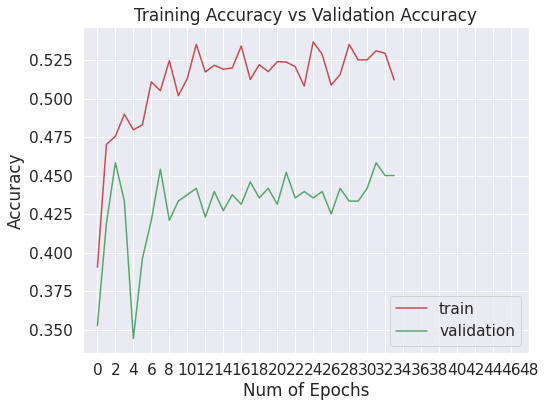

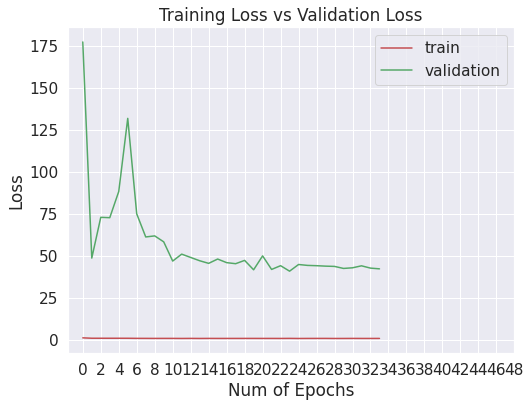

In [61]:
plot_train_vs_val(scnn)

### Predicción del modelo

Este modelo presenta unas métricas ligeramente inferiores a la **Red Neuronal Simple**. Podemos ver un sesgo hacia *Van Gogh* que puede venir dado por el desbalanceo.

In [62]:
scnn_pred = scnn_model.predict(x_test, batch_size=32, verbose=1)  
scnn_predicted = np.argmax(scnn_pred, axis=1)

602/602 [==============================] - 2s 3ms/step


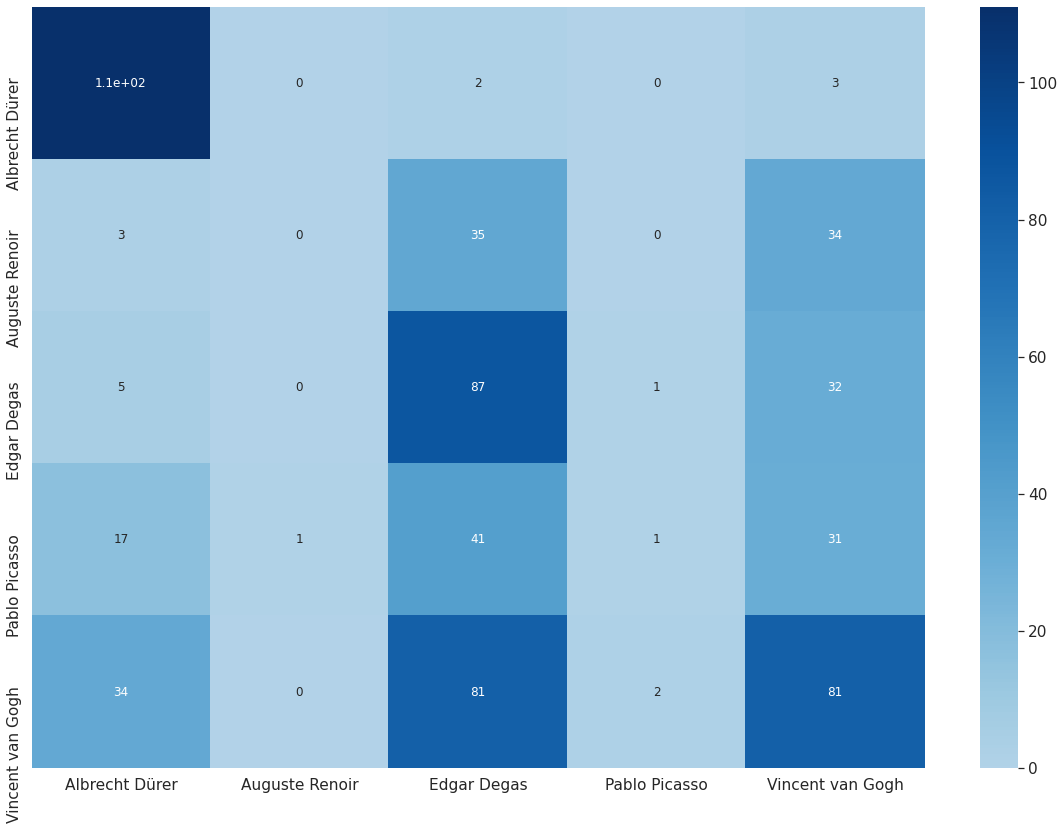

In [63]:
conf_matrix(num_classes, scnn_predicted) 

In [64]:
scnn_report = classification_report(np.argmax(y_test, axis=1), scnn_predicted, target_names=target_names)  
print(scnn_report) 

                  precision    recall  f1-score   support

  Albrecht Dürer       0.65      0.96      0.78       116
  Auguste Renoir       0.00      0.00      0.00        72
     Edgar Degas       0.35      0.70      0.47       125
   Pablo Picasso       0.25      0.01      0.02        91
Vincent van Gogh       0.45      0.41      0.43       198

        accuracy                           0.47       602
       macro avg       0.34      0.41      0.34       602
    weighted avg       0.38      0.47      0.39       602



La imagen de prueba no la clasifica bien, confunde a *Degas* con *Van Gogh*.

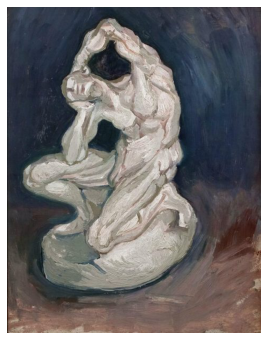

Artista real      :   Vincent van Gogh
Artista predicho  :   Albrecht Dürer


In [65]:
test_img(scnn_predicted)

### Conclusiones

La arquitectura de la **red neuronal simple** da mejores resultados en cuanto a *accuracy*. Queda compararla con el comportamiento de las redes preentrenadas con nuestro conjunto de imágenes.

### Guardar los resultados

In [66]:
guardar(scnn_model, "scnn_model")

## VGG-16 

La red **VGG16** es una de las primeras redes neuronales profundas. Se trata de una **red convolucional preentrenada** con una arquitectura fácil de comprender, con 13 capas convolucionales y 3 densas, de ahí el nombre. Esta red fue entrenada para resolver un problema de clasificación de 1000 clases.

<img src="img/vgg_esquema.png" alt="vgg"/>

## Crear la red

Se sigue la misma estructura que con los modelos anteriores. Para este caso se tendrán en cuenta los siguientes parámetros:
* **include_top**: Añade una red neuronal densa al final.
* **weights**: No se cargarán modelos concretos preentrenados previamente hasta más adelante.
* **input_tensor**: No se especificará ningún tensor de keras.
* **input_shape**: Define la dimensión de los datos de entrada.
* **pooling**: No se especificará.
* **classes**: Indica el número de clases.

In [67]:
def create_vgg16():  
    model = vgg16.VGG16(include_top=True,
                        weights=None,
                        input_tensor=None,
                        input_shape=x_train[0].shape,
                        pooling=None,
                        classes=num_classes)

    return model

In [68]:
vgg16_model = create_vgg16()  
vgg16_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', 'mse']) 

Echamos un vistazo al modelo que hemos creado. Vemos que añade capa de *InputLayer* al principio. 

In [69]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

Presenta más de **50 millones de parámetros** para entrenar, frente a los 3 millones de la red neuronal simple o los 47 de la red convolucional.

## Entrenar el modelo

En este caso nos encontramos con un tiempo de espera de **8/9 segundos** por *epoch*, con un total de 11 *epochs*, lo que hacen poco más de 1,5 minutos. La función <code>EarlyStopping</code> ha parado el entreno.

In [70]:
vgg16 = vgg16_model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(x_train) // batch_size,
    epochs=epochs,
    verbose=1,
    callbacks = callbacks,
    validation_data=(x_val, y_val),
    shuffle=True)

Epoch 1/100
60/60 [==============================] - 12s 204ms/step - loss: 4.8334 - acc: 0.2555 - mse: 0.1600 - val_loss: 1.5760 - val_acc: 0.2884 - val_mse: 0.1575
Epoch 2/100
60/60 [==============================] - 9s 142ms/step - loss: 1.5611 - acc: 0.2814 - mse: 0.1562 - val_loss: 1.5697 - val_acc: 0.2884 - val_mse: 0.1569
Epoch 3/100
60/60 [==============================] - 9s 143ms/step - loss: 1.5575 - acc: 0.2677 - mse: 0.1562 - val_loss: 1.5780 - val_acc: 0.2884 - val_mse: 0.1575
Epoch 4/100
60/60 [==============================] - 9s 143ms/step - loss: 1.5536 - acc: 0.2782 - mse: 0.1560 - val_loss: 1.5696 - val_acc: 0.2884 - val_mse: 0.1569
Epoch 5/100
60/60 [==============================] - 9s 143ms/step - loss: 1.5570 - acc: 0.2825 - mse: 0.1558 - val_loss: 1.5733 - val_acc: 0.2884 - val_mse: 0.1572
Epoch 6/100
60/60 [==============================] - 9s 151ms/step - loss: 1.5620 - acc: 0.2746 - mse: 0.1564 - val_loss: 1.5746 - val_acc: 0.2884 - val_mse: 0.1573

Epoch 00

## Evaluación del modelo

Con las gráficas de evolución se observa cómo este modelo parece no "aprender" bien. El *accuracy* se comporta de forma errática y el *loss* parece ir bien encaminado en el primer *epoch* pero luego se mantiene con altibajos. Los resultados finales no acompañan.

In [71]:
vgg16_evaluation = vgg16_model.evaluate_generator(train_generator.flow(x_train, y_train, batch_size=batch_size), verbose=1) 
vgg16_evaluation

61/61 [==============================] - 4s 65ms/step


[1.459389090538025, 0.28037384152412415, 0.15576337277889252]

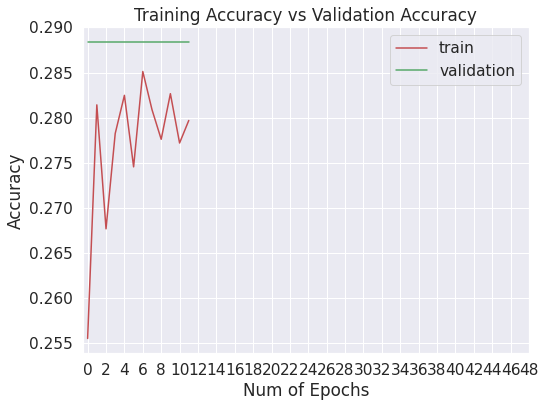

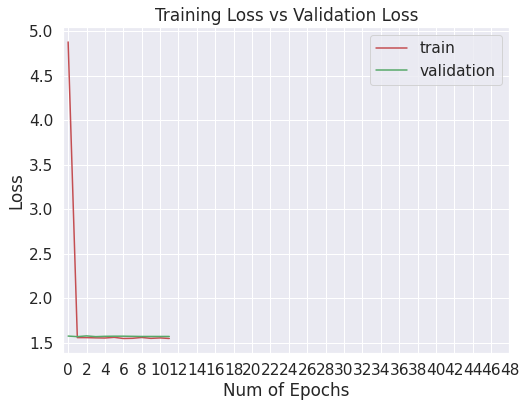

In [72]:
plot_train_vs_val(vgg16)

## Predicción del modelo

Al compararlo con las imágenes de test vemos como, efectivamente, el modelo se comporta de forma errática, obteniendo un 18% de *accuracy*, una cifra bastante baja.

In [73]:
vgg16_pred = vgg16_model.predict(x_test, batch_size=32, verbose=1)  
vgg16_predicted = np.argmax(vgg16_pred, axis=1)  

602/602 [==============================] - 1s 2ms/step


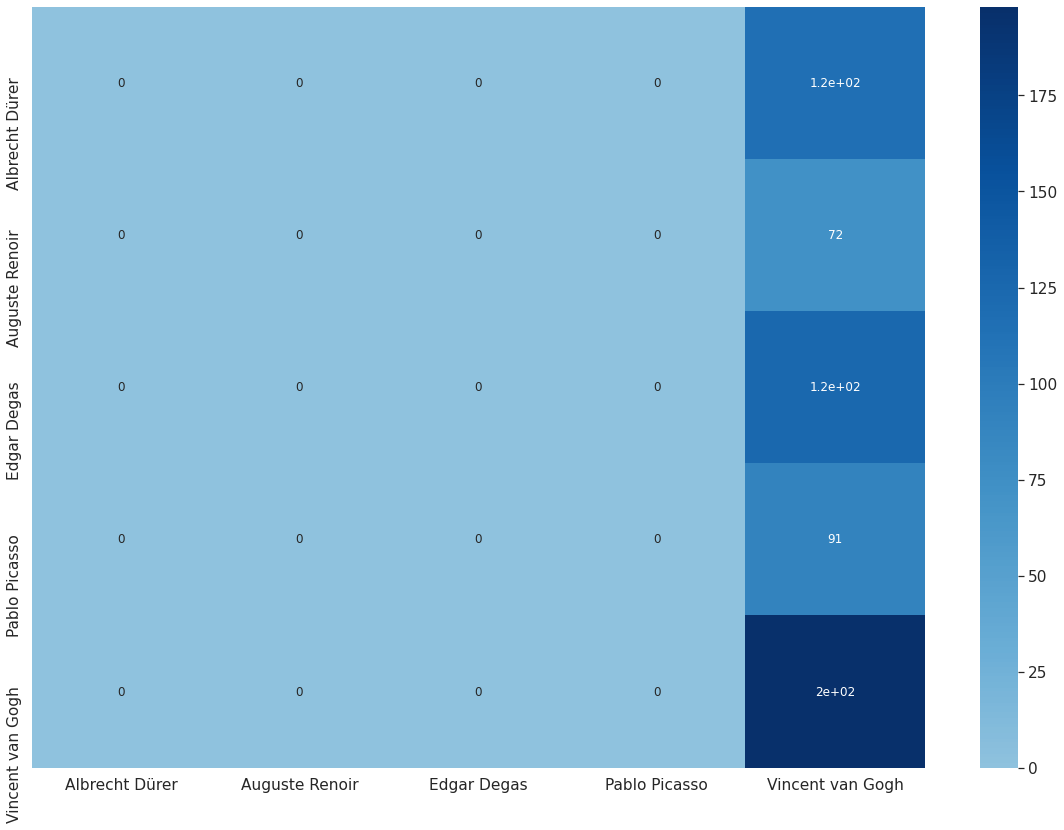

In [74]:
conf_matrix(num_classes, vgg16_predicted)

In [75]:
vgg16_report = classification_report(np.argmax(y_test, axis=1), vgg16_predicted, target_names=target_names)  
print(vgg16_report)

                  precision    recall  f1-score   support

  Albrecht Dürer       0.00      0.00      0.00       116
  Auguste Renoir       0.00      0.00      0.00        72
     Edgar Degas       0.00      0.00      0.00       125
   Pablo Picasso       0.00      0.00      0.00        91
Vincent van Gogh       0.33      1.00      0.49       198

        accuracy                           0.33       602
       macro avg       0.07      0.20      0.10       602
    weighted avg       0.11      0.33      0.16       602



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


La imagen aleatoria del conjunto de test no la clasifica bien.

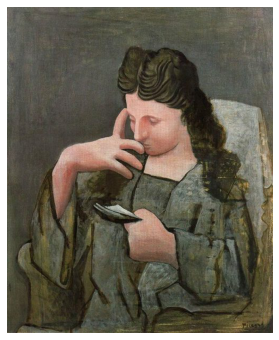

Artista real      :   Pablo Picasso
Artista predicho  :   Vincent van Gogh


In [76]:
test_img(vgg16_predicted)

## Conclusiones

Usar una red preentrenada sin ajustar no da buenos resultados.

## Guardar los resultados

In [77]:
guardar(vgg16_model, "vgg16_model")

# DenseNet121

Una de las principales mejoras que presenta **DenseNet** es que consiguó acortar las conexiones entre capas cercanas a la entrada y la salida, aumentando así la densidad de la red. Se trata de una red recursiva donde todas las capas están conectadas entre sí, y por tanto cada capa utiliza los datos de las demás.


<img src="img/densenet_esquema.png" alt="vgg_test"/>

## Crear la red

In [78]:
def build_DenseNet_model():  
    base_model = densenet.DenseNet121(input_shape=x_train[0].shape,
                                     include_top=False,
                                     pooling='avg')
    
    #Añadimos algunas capas más

    x = base_model.output
    x = Dense(1000, kernel_regularizer=regularizers.l1_l2(0.01), activity_regularizer=regularizers.l2(0.01))(x)
    x = Activation('relu')(x)
    x = Dense(500, kernel_regularizer=regularizers.l1_l2(0.01), activity_regularizer=regularizers.l2(0.01))(x)
    x = Activation('relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    return model


In [79]:
densenet_model = build_DenseNet_model()  
densenet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', 'mse'])  

29089792/29084464 [==============================] - 1s 0us/step


In [80]:
#densenet_model.summary()

## Entrenar la red

In [81]:
densenet = densenet_model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=batch_size) ,
    steps_per_epoch=len(x_train)// batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(x_val, y_val),
    callbacks = callbacks,
    shuffle=True)

Epoch 1/100
60/60 [==============================] - 69s 1s/step - loss: 342.8906 - acc: 0.2835 - mse: 0.1599 - val_loss: 194.7440 - val_acc: 0.3278 - val_mse: 0.1583
Epoch 2/100
60/60 [==============================] - 12s 202ms/step - loss: 141.6700 - acc: 0.3010 - mse: 0.1578 - val_loss: 100.6114 - val_acc: 0.2946 - val_mse: 0.1579
Epoch 3/100
60/60 [==============================] - 12s 203ms/step - loss: 76.1806 - acc: 0.2951 - mse: 0.1571 - val_loss: 55.3270 - val_acc: 0.2884 - val_mse: 0.1575
Epoch 4/100
60/60 [==============================] - 12s 202ms/step - loss: 41.3644 - acc: 0.2841 - mse: 0.1565 - val_loss: 29.4874 - val_acc: 0.2884 - val_mse: 0.1573
Epoch 5/100
60/60 [==============================] - 12s 203ms/step - loss: 21.9450 - acc: 0.2798 - mse: 0.1566 - val_loss: 15.7120 - val_acc: 0.2884 - val_mse: 0.1572
Epoch 6/100
60/60 [==============================] - 12s 203ms/step - loss: 11.9077 - acc: 0.2756 - mse: 0.1565 - val_loss: 8.8234 - val_acc: 0.2884 - val_mse:

## Evaluar el modelo

In [82]:
densenet_evaluation = densenet_model.evaluate_generator(train_generator.flow(x_train, y_train, batch_size=batch_size), verbose=1) 
densenet_evaluation

61/61 [==============================] - 4s 66ms/step


[1.6221282482147217, 0.28037384152412415, 0.15581798553466797]

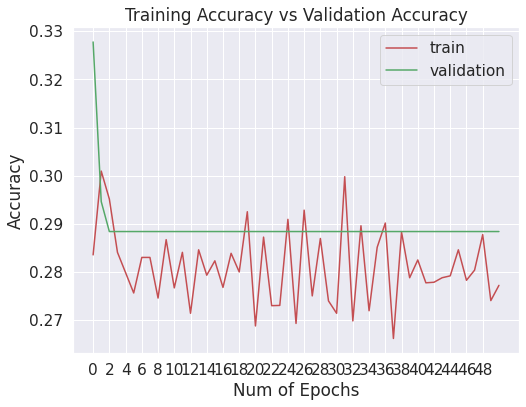

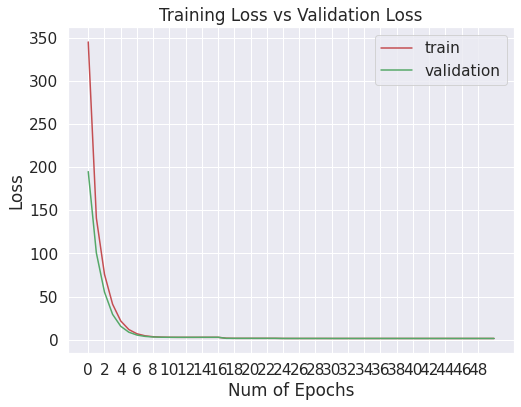

In [83]:
plot_train_vs_val(densenet)

## Predicción del modelo

In [84]:
densenet_pred = densenet_model.predict(x_test, batch_size=32, verbose=1)  
densenet_predicted = np.argmax(densenet_pred, axis=1)  

602/602 [==============================] - 3s 5ms/step


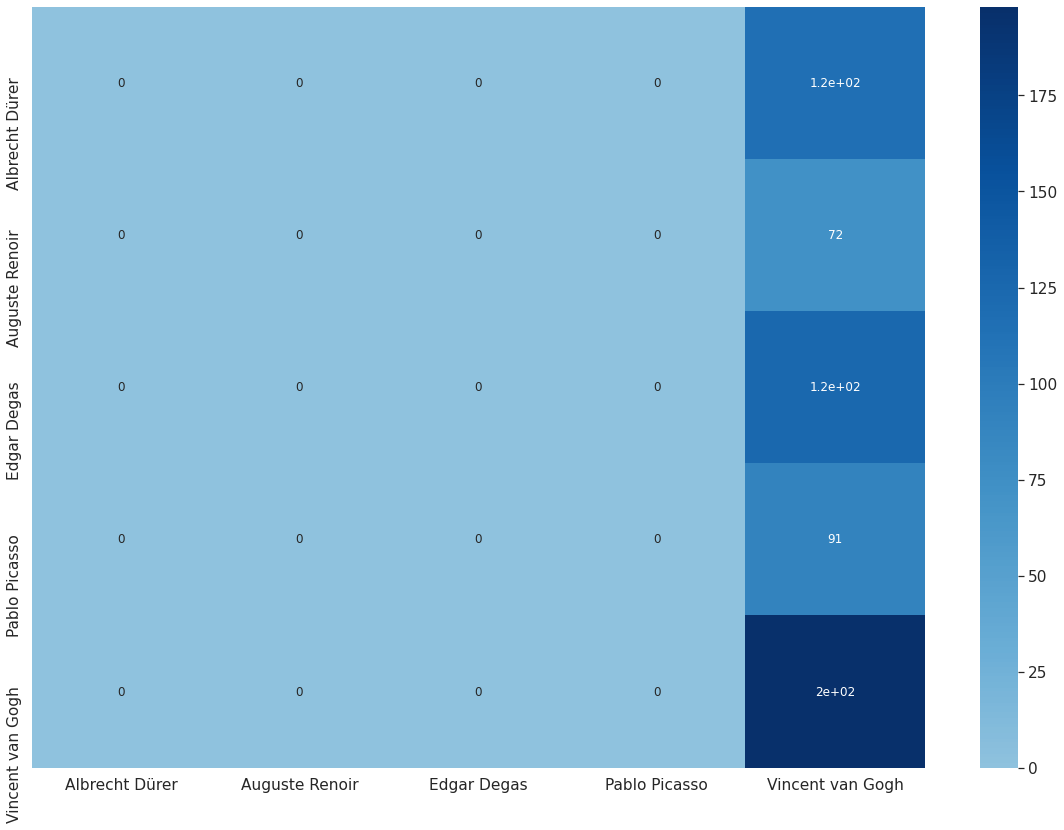

In [85]:
conf_matrix(num_classes, densenet_predicted)

In [86]:
densenet_report = classification_report(np.argmax(y_test, axis=1), densenet_predicted, target_names=target_names)  
print(densenet_report)

                  precision    recall  f1-score   support

  Albrecht Dürer       0.00      0.00      0.00       116
  Auguste Renoir       0.00      0.00      0.00        72
     Edgar Degas       0.00      0.00      0.00       125
   Pablo Picasso       0.00      0.00      0.00        91
Vincent van Gogh       0.33      1.00      0.49       198

        accuracy                           0.33       602
       macro avg       0.07      0.20      0.10       602
    weighted avg       0.11      0.33      0.16       602



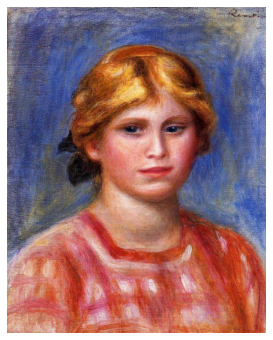

Artista real      :   Auguste Renoir
Artista predicho  :   Vincent van Gogh


In [87]:
test_img(vgg16_predicted)

## Conclusiones

Es la segunda que da peores resultados.

## Guardar el modelo

In [88]:
guardar(densenet_model, "densenet_model")

# IncepcionResNetV2 con ImageNet

En este caso se usará la red pre-entrenada *IncepcionResNetV2* con *ImageNet*. Se trata de una red convolucional que se ha entrenado con más de un millón de imagenes de *ImageNet*. *ImageNet* es un proyecto que proporciona una gran base de datos de imágenes con sus correspondientes anotaciones indicando el contenido de las imágenes. 

<img src="img/Inceptionresnetv2.png" alt="vgg_test"/>

## Creamos la red

A destacar el parámetro <code>include_top=False</code>. Este indica a la red que no debe incluir la última capa, destinada a realizar la predicción final. Esta capa está preparada para realizar las predicciones de todas las clases de ImageNet. Como se busca predecir únicamente las clases, esta capa se sustituirá por una personalizada.

La capa <code>GlobalAveragePooling2D</code> adaptará la salida de la capa anterior a la capa *softmax*.

A la función de creación de la red debe pasársele primero el parámetro <code>layers</code> que determina las capas del modelo a congelar. Tendremos que hacer varias pruebas hasta encontrar un número de capas a congelar adecuado.  

In [89]:
def build_IncepcionImagenet_model(layers):
    imagenet_model = InceptionResNetV2(weights='imagenet', include_top=False)
    x = imagenet_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(num_classes, activation='softmax')(x) 
    imagenet_model = Model(input=imagenet_model.input, output=predictions)
    for layer in imagenet_model.layers[:layers]:
        layer.trainable = False
    
    return imagenet_model

In [90]:
imagenet_model = build_IncepcionImagenet_model(700)

219062272/219055592 [==============================] - 54s 0us/step


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


In [91]:
imagenet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', 'mse'])

In [92]:
#imagenet_model.summary()

## Entrenamos el modelo

El entreno se ha realizado en 26 *epochs* de 5 segundos. La *accuracy* en relación al conjunto de validación es del 71%.

In [93]:
imagenet = imagenet_model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=batch_size) ,
    steps_per_epoch=len(x_train)// batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(x_val, y_val),
    callbacks = callbacks,
    shuffle=True)

Epoch 1/100
60/60 [==============================] - 15s 250ms/step - loss: 1.6267 - acc: 0.5132 - mse: 0.1335 - val_loss: 1.2564 - val_acc: 0.5664 - val_mse: 0.1174
Epoch 2/100
60/60 [==============================] - 5s 84ms/step - loss: 1.0509 - acc: 0.6325 - mse: 0.1023 - val_loss: 1.0245 - val_acc: 0.6349 - val_mse: 0.0971
Epoch 3/100
60/60 [==============================] - 5s 84ms/step - loss: 1.0216 - acc: 0.6674 - mse: 0.0918 - val_loss: 0.9662 - val_acc: 0.6743 - val_mse: 0.0935
Epoch 4/100
60/60 [==============================] - 5s 82ms/step - loss: 0.9191 - acc: 0.6895 - mse: 0.0888 - val_loss: 1.0484 - val_acc: 0.6515 - val_mse: 0.0990
Epoch 5/100
60/60 [==============================] - 5s 79ms/step - loss: 0.8657 - acc: 0.6790 - mse: 0.0873 - val_loss: 0.8991 - val_acc: 0.6826 - val_mse: 0.0868
Epoch 6/100
60/60 [==============================] - 5s 82ms/step - loss: 0.7529 - acc: 0.7239 - mse: 0.0778 - val_loss: 0.9342 - val_acc: 0.6556 - val_mse: 0.0947
Epoch 7/100
60

## Evaluamos el modelo

In [94]:
imagenet_evaluation = imagenet_model.evaluate_generator(train_generator.flow(x_train, y_train, batch_size=batch_size), verbose=1) 
imagenet_evaluation

61/61 [==============================] - 4s 68ms/step


[0.823143720626831, 0.830737292766571, 0.05039532110095024]

En el primer gráfico se presenta la *accuracy* obtenida en cada *epoch*, tanto para los datos de entrenamiento como los de test. En el segundo gráfico vemos la evolución en cada epoch de la *loss* para los dos conjuntos de datos. Estos son los mejores resultados hasta el momento.

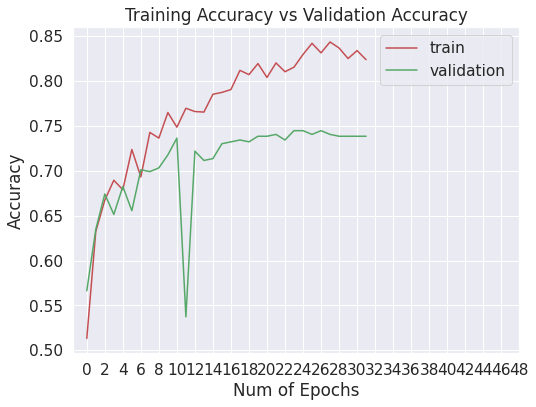

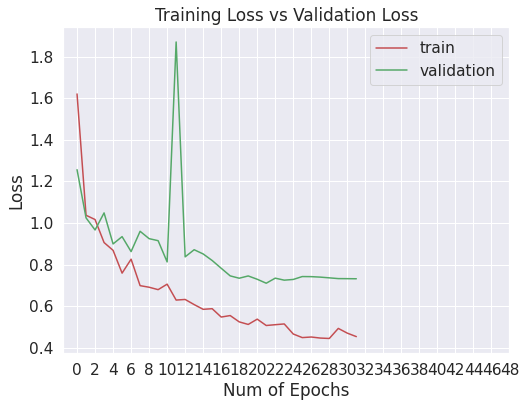

In [95]:
plot_train_vs_val(imagenet)

## Predicción del modelo

Consigue un 76% de *accuracy* frente al conjunto de test, siendo los 3 artistas más representados los que obtienen mejores métricas.

In [96]:
imagenet_pred = imagenet_model.predict(x_test, batch_size=batch_size, verbose=1)  
imagenet_predicted = np.argmax(imagenet_pred, axis=1) 

602/602 [==============================] - 4s 6ms/step


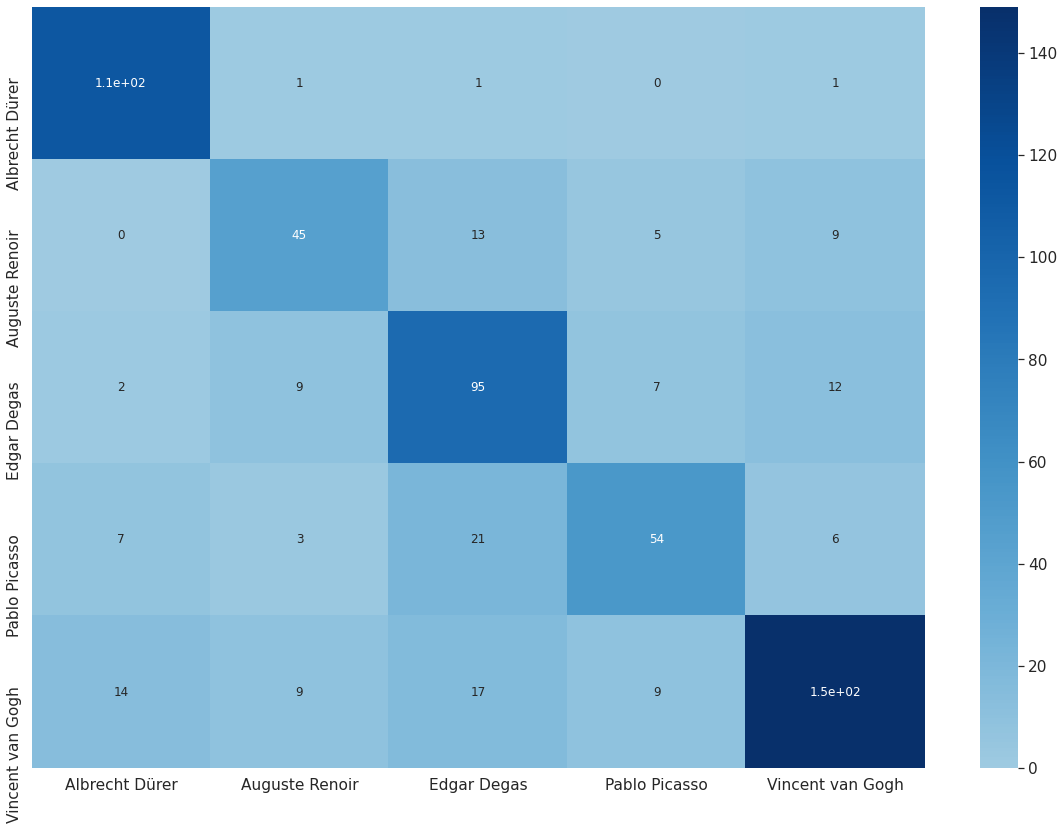

In [97]:
conf_matrix (num_classes, imagenet_predicted)

In [98]:
imagenet_report = classification_report(np.argmax(y_test, axis=1), imagenet_predicted, target_names=target_names)  
print(imagenet_report)

                  precision    recall  f1-score   support

  Albrecht Dürer       0.83      0.97      0.90       116
  Auguste Renoir       0.67      0.62      0.65        72
     Edgar Degas       0.65      0.76      0.70       125
   Pablo Picasso       0.72      0.59      0.65        91
Vincent van Gogh       0.84      0.75      0.79       198

        accuracy                           0.76       602
       macro avg       0.74      0.74      0.74       602
    weighted avg       0.76      0.76      0.76       602



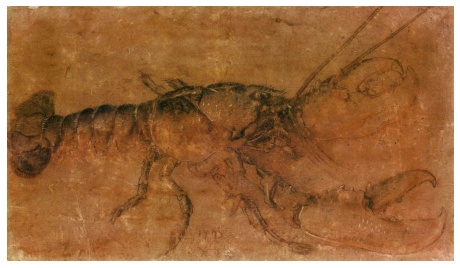

Artista real      :   Albrecht Dürer
Artista predicho  :   Auguste Renoir


In [99]:
test_img(imagenet_predicted)

## Conclusiones

Es, con diferencia, la red que de entrada da mejores resultados. Ha completado el entreno en poco tiempo y es la que obtiene mejores métricas en los artistas menos representados.

## Guardar los resultados

In [100]:
guardar(imagenet_model, "imagenet_model")

# NASNet

Alrededor de noviembre de 2017 el proyecto AutoML de Google creó NASNet, un sistema optimizado para ImageNet. Fue entrenada para la identificación y reconocimiento de imágenes con más de 60.000 imágenes y 1000 categorías diferentes. Tiene un tamaño de entrada por defecto de 224 por 224. Puede dar una baja *accuracy* en datasets grandes.

<img src="img/nasnet_esquema.png" alt="nasnet"/>


## Creamos la red

Para crear esta red disponemos de varios parámetros de entrada:
*  <code>input_shape</code>: Al que se pasará el tamaño de las imágenes.
*  <code>include_top</code>: Incluye una capa conectada en la parte superior.
*  <code>weights</code>: Puede ser <code>None</code> o utilizar los pesos de *ImageNet*.
*  <code>input_tensor</code>: Tensor opcional de Keras.
*  <code>pooling</code>: Hace que el *output* del modelo sea un tensor 4D en la última capa convolucional.
*  <code>classes</code>: Número de clases a identificar.

In [101]:
def create_nasnet():  
    model = nasnet.NASNetMobile(input_shape=x_train[0].shape,
                                include_top=True,
                                weights=None,
                                input_tensor=None,
                                pooling=None,
                                classes=num_classes
                               )

    return model

In [102]:
nasnet_model = create_nasnet()  
nasnet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', 'mse']) 

In [103]:
#nasnet_model.summary()  

## Entrenamos el modelo

Al entrenar el modelo vemos que se ha detenido en el *epoch* 37. A 16 segundos por *epoch* el tiempo de espera ha sido de algo menos de **10 minutos**. El resultado de *accuracy* con respecto a la muestra de validación es del 71%.

In [ ]:
nasnet = nasnet_model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=batch_size) ,
    steps_per_epoch=len(x_train)// batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(x_val, y_val),
    callbacks = callbacks,
    shuffle=True)

Epoch 1/100
60/60 [==============================] - 155s 3s/step - loss: 1.2698 - acc: 0.5174 - mse: 0.1260 - val_loss: 1.2987 - val_acc: 0.4710 - val_mse: 0.1299
Epoch 2/100
60/60 [==============================] - 16s 261ms/step - loss: 1.1619 - acc: 0.5723 - mse: 0.1152 - val_loss: 1.1290 - val_acc: 0.5041 - val_mse: 0.1179
Epoch 3/100
60/60 [==============================] - 16s 262ms/step - loss: 1.0886 - acc: 0.5945 - mse: 0.1098 - val_loss: 1.2821 - val_acc: 0.5228 - val_mse: 0.1306
Epoch 4/100
60/60 [==============================] - 16s 264ms/step - loss: 1.0146 - acc: 0.6140 - mse: 0.1029 - val_loss: 1.0660 - val_acc: 0.5975 - val_mse: 0.1090
Epoch 5/100
60/60 [==============================] - 16s 259ms/step - loss: 0.9793 - acc: 0.6262 - mse: 0.0990 - val_loss: 1.1171 - val_acc: 0.5851 - val_mse: 0.1104
Epoch 6/100
60/60 [==============================] - 16s 263ms/step - loss: 0.9701 - acc: 0.6297 - mse: 0.0980 - val_loss: 0.9934 - val_acc: 0.6349 - val_mse: 0.1005
Epoch 

## Evaluamos el modelo

La función de pérdida y el error medio cuadrático presentan buenas cifras, que van descendiendo a lo largo del entreno. La *accuracy* también mejora hasta el *epoch* 30, donde se estanca en el conjunto de validación.

In [ ]:
nasnet_evaluation = nasnet_model.evaluate_generator(train_generator.flow(x_train, y_train, batch_size=batch_size), verbose=1) 
nasnet_evaluation

In [ ]:
plot_train_vs_val(nasnet)

## Predicción del modelo

La diagonal descendente en la matriz de confusión indica buenos resultados. El <code>classification_report</code> muestra cómo *Auguste Renoir* y *Pablo Picasso* son los peor clasificados; podría deberse a un menor soporte en el conjunto total de datos.

In [ ]:
nasnet_pred = nasnet_model.predict(x_test, batch_size=batch_size, verbose=1)  
nasnet_predicted = np.argmax(nasnet_pred, axis=1)

conf_matrix(num_classes, nasnet_predicted) 

In [ ]:
nasnet_report = classification_report(np.argmax(y_test, axis=1), nasnet_predicted, target_names=target_names)  
print(nasnet_report)

## Conclusiones

La red *NasNET* tiene buenos resultados, pero un *accuracy* más bajo en un tiempo de ejecución más alto que *InceptionResNetV2*.

## Guardar los resultados

In [ ]:
guardar(nasnet_model, "nasnet_model")

# Comparativa de modelos y conclusiones finales

Se han analizado diversas redes, las dos primeras creadas desde 0, frente al uso de diferentes arquitecturas ya creadas, así como de pesos ya entrenados. 

Se ha demostrado que un mayor número de parámetros no implica mejores resultados. Esto se ve claramente en el caso de los *VGG16* y la red neuronal simple, la primera con más de 50 millones de parámetros y un *accuracy* del 33% frente a los 3 millones de parámetros y 55% de aciertos.

Los tiempos indicados son los obtenidos con la GPU NVIDIA K80, con la máquina virtual de 60 GB de memoria los modelos con más parámetros llegaron a tardar 12 horas.

En las siguientes gráficas se puede observar la evolución de las métricas de los modelos a lo largo del proceso de entreno. En la primera vemos como el ***accuracy*** de las redes *NasNet* e *InceptionResNetV2* con *ImageNet* son los que presentan una mejor evolución. La red neuronal simple y la convolucional las siguen con unos números bastante inferiores y parándose al no mejorar. Resulta llamativo el comportamiento estático de *DenseNet*, habría que revisar si este proceso ha sido llevado a cabo correctamente. Por último, la red *VGG16* es la que presenta peores resultados con diferencia.

In [ ]:
plt.plot(snn.history['val_acc'])
plt.plot(nasnet.history['val_acc'])
plt.plot(imagenet.history['val_acc'])
plt.plot(densenet.history['val_acc'])
plt.plot(vgg16.history['val_acc'])
plt.plot(scnn.history['val_acc'])
plt.xticks(np.arange(0, 50, 2.0))
plt.rcParams['figure.figsize'] = (15, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Accuracy")  
plt.legend(['RNSimple','Nasnet','ImageNet', 'DenseNet', 'VGG16', 'RNConv'])  

In [ ]:
plt.plot(snn.history['val_loss'])
plt.plot(nasnet.history['val_loss'])
plt.plot(imagenet.history['val_loss'])
plt.plot(densenet.history['val_loss'])
plt.plot(vgg16.history['val_loss'])
plt.plot(scnn.history['val_loss'])
plt.xticks(np.arange(0, 50, 2.0))
plt.rcParams['figure.figsize'] = (15, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Loss")  
plt.legend(['RNSimple','Nasnet','ImageNet', 'DenseNet', 'VGG16', 'RNConv'])  

In [ ]:
plt.plot(snn.history['val_mse'])
plt.plot(nasnet.history['val_mse'])
plt.plot(imagenet.history['val_mse'])
plt.plot(densenet.history['val_mse'])
plt.plot(vgg16.history['val_mse'])
plt.plot(scnn.history['val_mse'])
plt.xticks(np.arange(0, 50, 2.0))
plt.rcParams['figure.figsize'] = (15, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("MSE")  
plt.title("MSE")  
plt.legend(['RNSimple','Nasnet','ImageNet', 'DenseNet', 'VGG16', 'RNConv']) 